<a href="https://colab.research.google.com/github/leandroleao2k/ImageML/blob/main/PCA%20Reducao%20Dimensionalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PCA 
##1) Normalização para dados ter media 0 e desvio padrão 1
##2) Calcular a matriz de covariância: 
Variancia quao espalhados estao os dados e
CoVariancia qual orientação   
##3) Calculo dos Autovetores e Autovalores da matriz de coVariancia
Isso vai caracterizar os dados onde os autovetores tentam capturar a variancia dos componentes
##4) Selecionar componentes principais
o autovetor com maior autovalor é o 1o 
##5) Executar a redução dimensionalidade 

https://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca

(1797, 64)
(1797, 8, 8)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180]))
(8, 8)


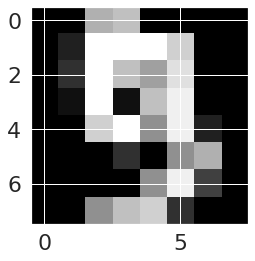

In [68]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Ellipse

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits

%matplotlib inline
digits = load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(np.unique(digits.target, return_counts=True))

plt.gray()
plt.imshow(digits.images[9])
print(digits.images[9].shape)
#sns.set(style='darkgrid', context='talk', rc={'figure.figsize': (20, 5)})

# Aplicando PCA

In [69]:
pca = PCA(n_components=8)
df_train = digits.data
pcaf = pca.fit(df_train)
print(pca.components_.shape)
pcaf.explained_variance_

(8, 64)


array([179.00693009, 163.71774687, 141.78843902, 101.10037484,
        69.51313316,  59.10851367,  51.88442596,  44.01492855])

## Avaliar Variancia
os prinmeiros components que mais explicam a variancia dos dados ex PC1, 2 e 3

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']


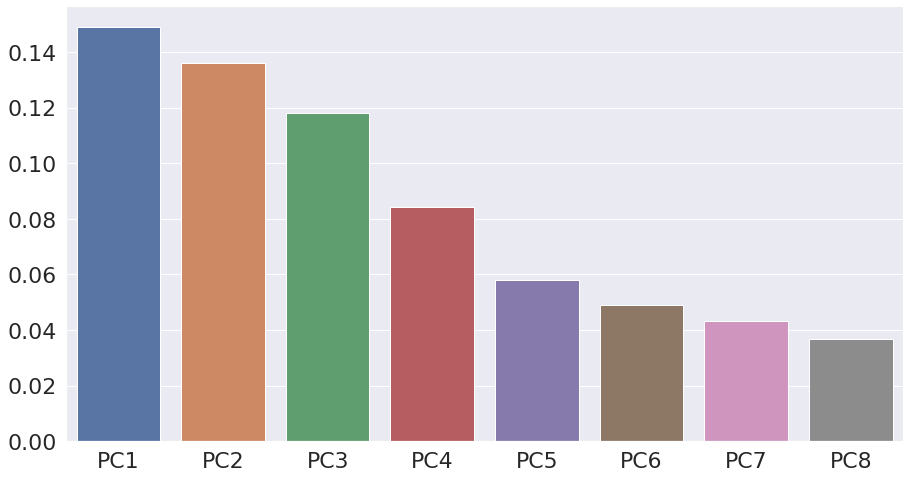

In [70]:
pc_lables = [] 
for i in range(pca.components_.shape[0]):
  pc_lables.append('PC{}'.format(i+1))
print(pc_lables)

plt.rcParams['figure.figsize'] = (15,8)
df = {
    'variance' : pca.explained_variance_ratio_,
    'principal_components' : pc_lables
}

sns.set(font_scale=2)
sns.barplot(x='principal_components', y='variance', data=df)

# Fazer a Transformaçao

In [71]:
df_transformed = pca.fit_transform(df_train)
df_transformed = pd.DataFrame(df_transformed, columns=pc_lables)
df_transformed.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.259560,21.275021,-9.462688,13.013217,-7.137122,-7.441284,3.272240,2.514338
1,7.957540,-20.768701,4.438755,-14.894422,5.890345,-6.485068,2.135193,-4.661220
2,6.991853,-9.955915,2.958090,-12.288576,-18.122964,-4.495606,1.837102,-16.413133
3,-15.906129,3.332531,9.825071,-12.276152,6.960070,1.084364,-1.029416,10.961842
4,23.306891,4.269142,-5.675064,-13.851197,-0.358235,-2.853348,-0.722859,13.036069


# Escolha dos Componentes
## PC 1 x PC2

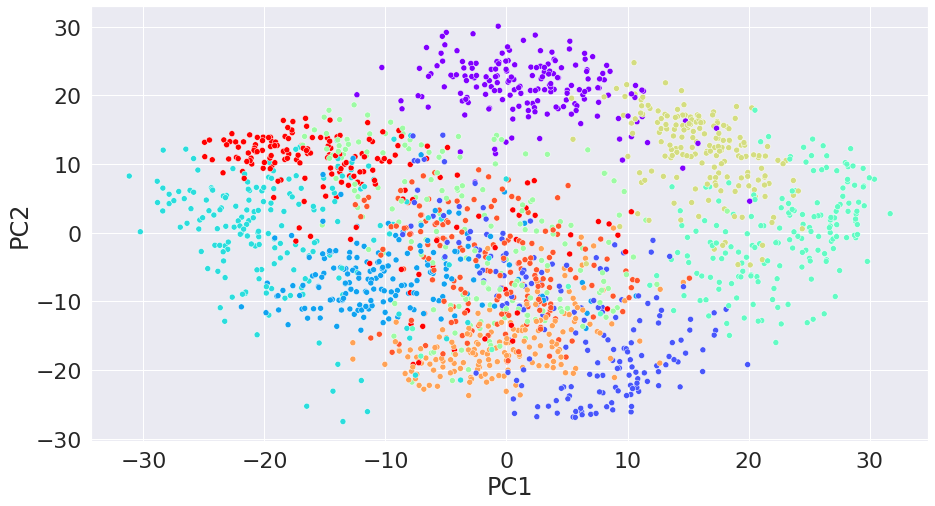

In [72]:
df = pd.DataFrame(df_transformed, columns=['PC1','PC2'])
df['label'] = digits.target
_ = sns.scatterplot(x='PC1', y='PC2', data=df, hue='label', palette='rainbow', legend=False)

## PC 2 x 4

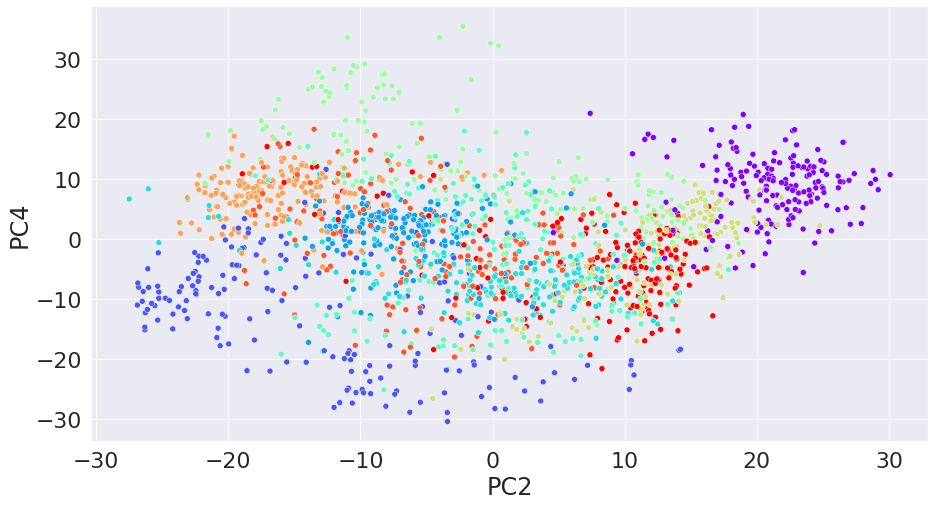

In [73]:
df = pd.DataFrame(df_transformed, columns=['PC2','PC4'])
df['label'] = digits.target
_ = sns.scatterplot(x='PC2', y='PC4', data=df, hue='label', palette='rainbow', legend=False)

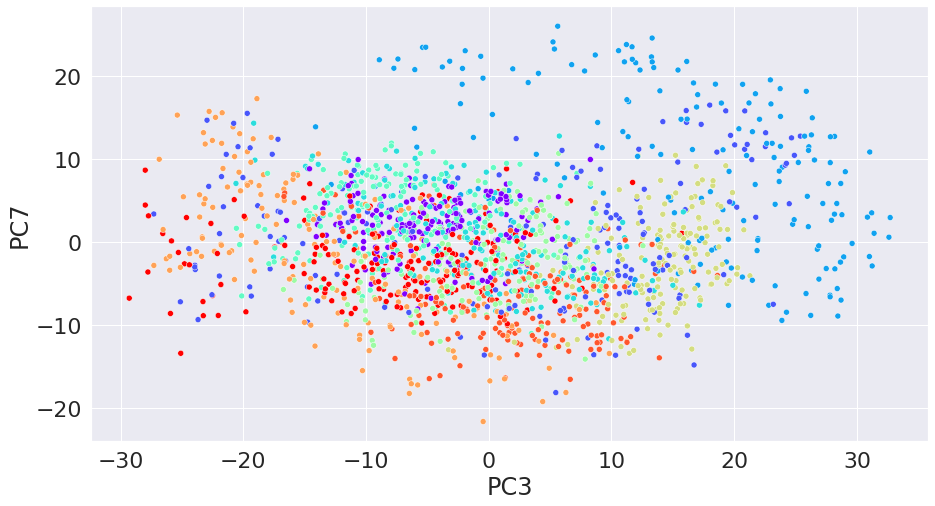

In [74]:
df = pd.DataFrame(df_transformed, columns=['PC3','PC7'])
df['label'] = digits.target
_ = sns.scatterplot(x='PC3', y='PC7', data=df, hue='label', palette='rainbow', legend=False)